In [246]:
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix, csr_matrix, lil_matrix, bmat, eye
from scipy.sparse import random, block_diag, diags
from networkx.algorithms import bipartite
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from heapq import nlargest
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100


def to_graph(A):
    return bipartite.matrix.from_biadjacency_matrix(A)

def gcc(graph):
    return graph.subgraph(max(nx.connected_components(graph), key=len))

def top_bottom(graph):
    top_nodes = {n for n, d in graph.nodes(data=True) if d["bipartite"] == 0}
    bottom_nodes = set(graph) - top_nodes
    return top_nodes, bottom_nodes

def largest_hubs(graph, k=0.2):
    top, bottom = top_bottom(graph)
    m_top = max(1, int(len(top) * k))
    m_bot = max(1, int(len(bottom) * k))
    degree = lambda x: graph.degree[x]
    top_largest = nlargest(m_top, top, key=degree)
    bottom_largest = nlargest(m_bot, bottom, key=degree)
    return top_largest, bottom_largest

def reduce(graph, k=0.2):
    top_largest, bottom_largest = largest_hubs(graph, k)
    graph.remove_nodes_from(top_largest + bottom_largest)
    new_graph = gcc(graph).copy()
    graph.remove_nodes_from(new_graph.nodes())
    print(len(graph), len(new_graph), len(top_largest + bottom_largest))
    return (*top_bottom(graph), new_graph, top_largest, bottom_largest)

def permute(A, k=0.2):
    graph = to_graph(A)
    top, bottom = top_bottom(graph)
    m_top = max(1, int(len(top) * k))
    m_bot = max(1, int(len(bottom) * k))
    nt = []
    nb = []
    perm_top_lhs = []
    perm_top_rhs = []
    perm_bot_lhs = []
    perm_bot_rhs = []
    while m_top < len(top) and m_bot < len(bottom):
        m_top = max(1, int(len(top) * k))
        m_bot = max(1, int(len(bottom) * k))
        ptl, pbl, graph, ptr, pbr = reduce(graph, k)
        perm_top_lhs = perm_top_lhs + list(ptl)
        perm_bot_lhs = perm_bot_lhs + list(pbl)
        perm_top_rhs = list(ptr) + perm_top_rhs
        perm_bot_rhs = list(pbr) + perm_bot_rhs
        nt.append(len(perm_top_lhs))
        nb.append(len(perm_bot_lhs))
        top, bottom = top_bottom(graph)
    perm_top = np.array(perm_top_lhs + list(top) + perm_top_rhs)
    perm_bot = np.array(perm_bot_lhs + list(bottom) + perm_bot_rhs) - A.shape[0]
    return A[perm_top].T[perm_bot].T, perm_top, perm_bot, nt + [len(perm_top_lhs)], nb + [len(perm_bot_lhs)]

def get_permuted_blocks(A, k=0.2):
    B, perm_top, perm_bot, nt, nb = permute(A, k)
    m1, n1 = nt[-1], nb[-1]
    A_11 = B[:m1, :n1]
    A_21 = B[m1:, :n1]
    T = B[:, n1:]
    return A_11, A_21, T, nt, nb, perm_top, perm_bot
    
def phase1(A_11, nt, nb, alpha):
    U_blocks = []
    S_blocks = []
    VT_blocks = []
    i0 = 0
    j0 = 0
    for i1, j1 in zip(nt, nb):
        if i1 == i0 and j1 == j0:
            continue
        m = i1 - i0
        n = j1 - j0
        s = int(np.ceil(min(m, n) * alpha))
        U_, S_, VT_ = svds(A_11[i0: i1, j0: j1], k=s)
        U_blocks.append(U_)
        S_blocks.append(diags(S_))
        VT_blocks.append(VT_)
        i0 = i1
        j0 = j1
    U = block_diag(U_blocks)
    S = block_diag(S_blocks)
    VT = block_diag(VT_blocks)
    return U, S, VT
    
    
def phase2(U, S, VT, A_21):
    s = S.shape[0]
    #print(VT.shape, A_21.shape)
    rhs = bmat([[S @ VT], [A_21]], format='csr')
    lhs = block_diag([U, eye(A_21.shape[0], format='lil')], format='csr')
    #print(type(svds(rhs, k=s)[0]))
    U_ = lhs @ svds(rhs, k=s)[0]
    return U_, S, VT

def phase3(U, S, VT, T, alpha):
    rhs = block_diag([VT, eye(T.shape[1], format='lil')], format='csc')
    lhs = bmat([[U @ S, T]])
    r = int(np.ceil(min(*lhs.shape) * alpha))
    U_, S_, VT_ = svds(lhs, k=r)
    return U_, S_, VT_ @ rhs


def FastPI(A, alpha=0.2, k=0.05):
    A_11, A_21, T, nt, nb, perm_top, perm_bot = get_permuted_blocks(A, k=0.2)
    U, S, VT = phase1(A_11, nt, nb, alpha)
    U, S, VT = phase2(U, S, VT, A_21)
    U, S, VT = phase3(U, S, VT, T, alpha)
    Sinv = 1 / S
    Sinv[Sinv != Sinv] = 0
    return VT.T @ diags(Sinv) @ U.T, perm_top, perm_bot


from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm

def plot_surface_function(x1_, x2_, y_, minmax_values=None, ax=None, zlabel=""):
    x1, x2 = np.meshgrid(x1_, x2_)
    y = np.array([[y_(i, j) for j in x2_] for i in x1_])
    if ax is None:
        fig = plt.figure()
        ax = Axes3D(fig)

        surf = ax.plot_surface(x1, x2, y, cmap=cm.rainbow, linewidth=0.5, alpha=0.5, edgecolor="k")
        if minmax_values is not None:
            ax.set_xlim3d(*minmax_values[0])
            ax.set_ylim3d(*minmax_values[1])
        ax.set_zlabel(zlabel)
    
    else:
        surf = ax.plot_surface(x1, x2, y, cmap=cm.bwr, linewidth=0.5, alpha=0.1, edgecolor="k")
        
    return ax
        








0 3800 200
0 3610 190
0 3430 180
0 3260 170
0 3098 162
0 2944 154
0 2798 146
0 2660 138
0 2528 132
0 2402 126
0 2282 120
0 2168 114
0 2060 108
0 1958 102
0 1862 96
0 1770 92
0 1682 88
0 1598 84
0 1520 78
0 1444 76
1 1371 72
0 1303 68
1 1238 64
0 1177 61
1 1118 58
1 1062 55
1 1009 52
2 957 50
8 903 46
8 851 44
31 778 42
33 707 38
106 567 34
202 337 28
172 149 16
42 101 6
33 64 4
28 34 2
18 14 2
8 4 2
1 1 2
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 7, 14, 30, 45, 95, 193, 281, 304, 320, 333, 343, 347, 347, 347] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 3, 3, 3, 5, 8, 9, 24, 42, 98, 202, 286, 305, 322, 337, 345, 349, 350, 350]


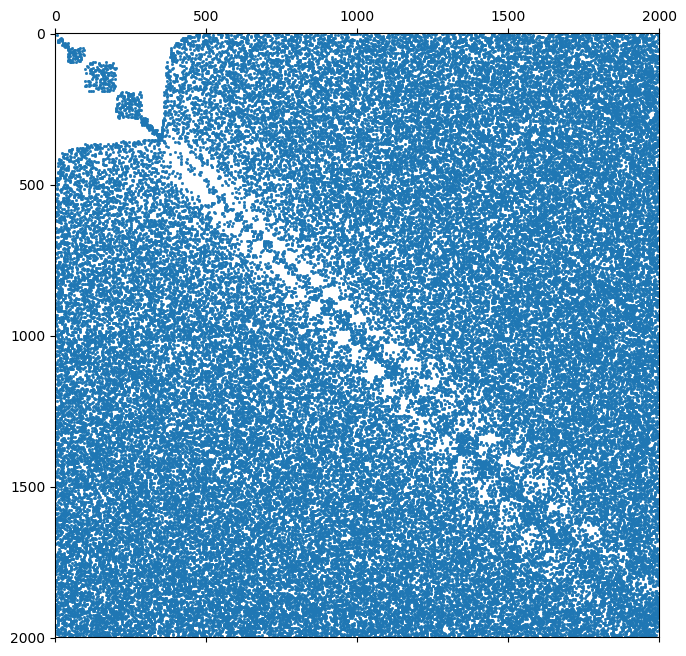

In [252]:
A = lil_matrix(random(2000, 2000, density=0.02))
B, _, _, nt, nb = permute(A, k = 0.05)
m1, n1 = nt[-1], nb[-1]
print(nt, nb)
plt.figure()
plt.spy(B, markersize=1)
plt.show()

868 732 400
564 22 146
868 732 400
564 22 146
868 732 400
564 22 146
868 732 400
564 22 146
868 732 400
564 22 146
868 732 400
564 22 146
868 732 400
564 22 146
868 732 400
564 22 146
868 732 400
564 22 146
868 732 400
564 22 146
868 732 400
564 22 146
868 732 400
564 22 146
868 732 400
564 22 146


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:121: RuntimeWarning: divide by zero encountered in true_divide
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in matmul


868 732 400
564 22 146
868 732 400
564 22 146
868 732 400
564 22 146


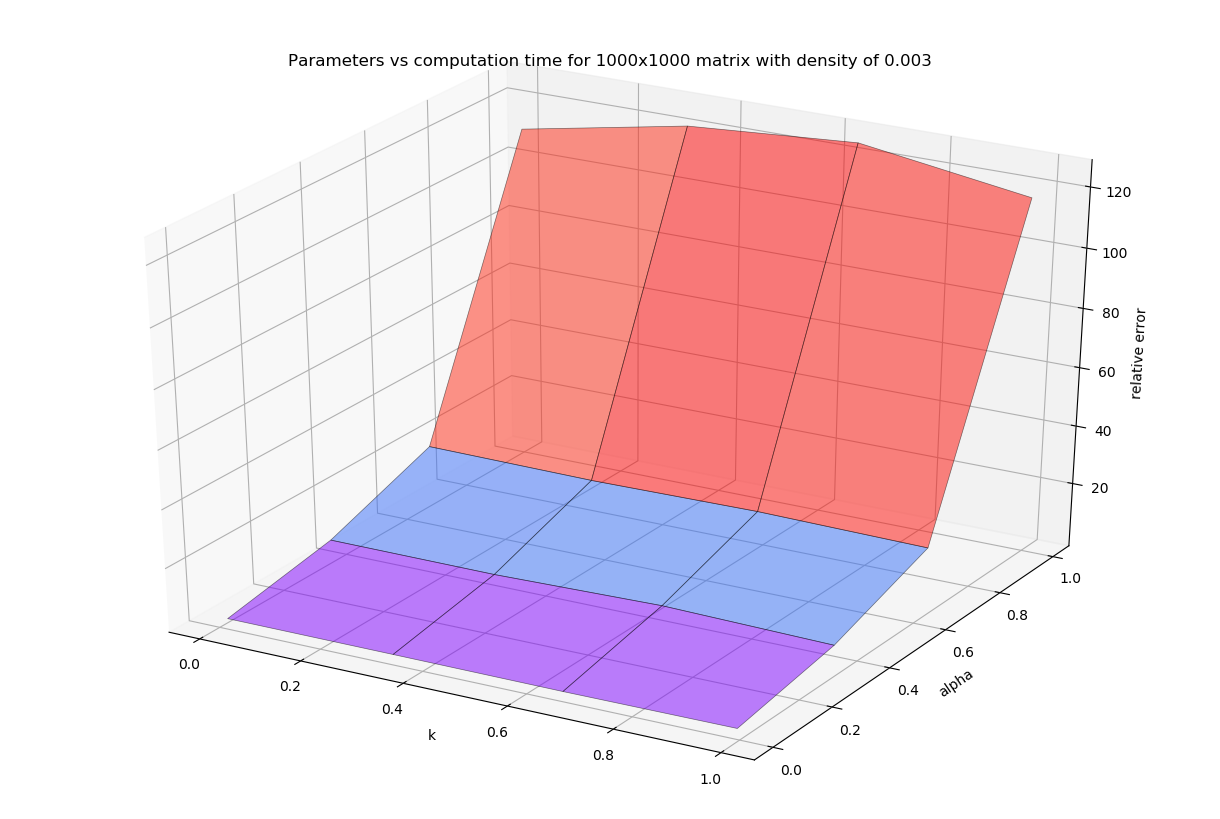

4.003058451053221


In [247]:
from timeit import timeit
#Ap = FastPI(A)[0]
ks = np.linspace(0.01, 0.99, 4, endpoint=True)
alphas = np.linspace(0.01, 0.99, 4, endpoint=True)

def reconstruction_error(x, y):
    Ap, pt, pb = FastPI(A, x, y)
    Ap_ = np.linalg.pinv(A[pt].T[pb].T.todense())
    return np.linalg.norm(Ap - Ap_) / np.linalg.norm(Ap_) 

def elapsed(x, y):
    return timeit("FastPI(A, %f, %f)" % (x, y), globals=globals(), number=1)

plot_surface_function(alphas, ks, elapsed, zlabel="relative error")
plt.xlabel("k")
plt.ylabel("alpha")
plt.title("Parameters vs computation time for 1000x1000 matrix with density of 0.003")
plt.show()
print(timeit("np.linalg.pinv(A.todense())", globals=globals(), number=1))

In [244]:
from timeit import timeit
FastPI(lil_matrix(np.eye(3)), k=0.05, alpha=0.01)


2 2 2


ValueError: k must be between 1 and min(A.shape), k=1